Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


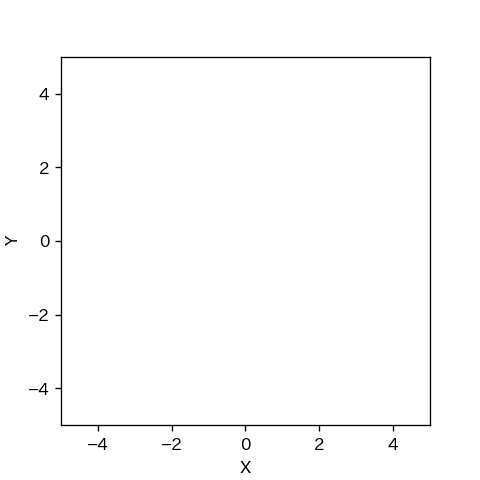

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([0,0,0]).T
    robot_pose=np.array([0,0,0]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


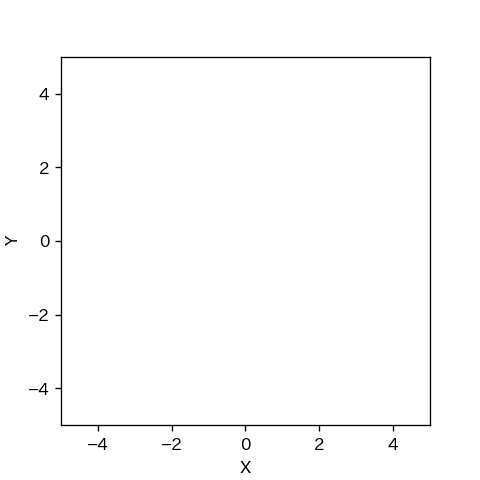

(array([0, 0, 0]), array([0, 0, 0]))

In [4]:
trial_trap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[5.155379563798515, 5.104165321785233]
[4.762107367559602, 5.225527890540786]
[4.386184299669432, 5.8533564549293144]
[4.67137605318669, 5.953994455629472]
[6.493807672604302]
[8.039935966361798]
0 真値: [0.5367911  1.78923328 2.55177852] 推定値: [-10.0891475    3.17971499  -0.7869878 ] 誤差: 10.716529779600403
1 真値: [-0.38664561  2.2050339   3.42593774] 推定値: [-0.69517636  2.5816877   3.51685638] 誤差: 0.4868873624048349
1
2 真値: [-0.83806591  2.49854716  3.62697088] 推定値: [-0.85694566  2.22219863  3.64513761] 誤差: 0.27699269869607196
2
3 真値: [-0.2043691   1.66601393  3.52906616] 推定値: [-0.33018139  2.0914632   3.68721914] 誤差: 0.4436618254774087
3
4 真値: [1.04213906 2.43929484 2.48298768] 推定値: [0.91900045 2.22492569 2.43727812] 誤差: 0.24721903602116205
4
5 真値: [-0.81283098  1.07184487  4.54969761] 推定値: [-1.02064922  0.99649619  4.59382462] 誤差: 0.22105620488711125
5
6 真値: [1.14664865 2.0082502  1.9980514 ] 推定値: [-0.44785716  1.84663396  4.3241279 ] 誤差: 1.6026754472857576
7 真値: [-0.23733727  2.06353704

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.84046601  0.85491232  4.72033346] 推定値: [-1.10735966  0.74976634  4.8736294 ] 誤差: 0.286858669650947
17
21 真値: [0.98043852 1.49789818 1.99322107] 推定値: [1.19529294 1.25802101 2.04109798] 誤差: 0.32203023965218164
18
22 真値: [0.24372525 1.92054107 2.96977759] 推定値: [0.15113368 2.36412881 3.08650172] 誤差: 0.4531481880319865
19
23 真値: [0.22316189 1.70323096 2.60191981] 推定値: [-0.55741404  2.72432687  2.85755533] 誤差: 1.2852764895320643
24 真値: [0.82817758 1.94730709 2.53874643] 推定値: [0.94734685 1.93255642 2.46593186] 誤差: 0.12007871263914024
20
25 真値: [-0.56707979  2.22571946  3.76133411] 推定値: [-0.91763998  1.8107276   3.69057368] 誤差: 0.5432409144293566
21
26 真値: [-0.02770006  2.29285842  3.04588116] 推定値: [-1.06153785  3.12824419  3.36615946] 誤差: 1.329168902616009
[4.241526896557037]
27 真値: [-0.23297858  2.22456934  3.22446355] 推定値: [-1.69192989 -0.48988827  2.29458694] 誤差: 3.081690937424787
28 真値: [1.47684622 1.88925977 2.06134716] 推定値: [-1.40320642  2.69858048  3.93527157] 誤差: 2.99160545